In [1]:
import os
import csv
import numpy as np 
import pandas as pd 

import networkx as nx 

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from munkres import Munkres

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

In [2]:
class ARGS():
    pass 

args = ARGS()

args.SEED = 100

BASE_path = f'{os.environ["HOME"]}/mouse_dataset/simulations'
os.system(f'mkdir -p {BASE_path}')

0

In [3]:
sizes = [25, 75, 50]
p = [
    [0.5, 0.1, 0.0],
    [0.1, 0.1, 0.0],
    [0.0, 0.0, 0.9]
]
G = nx.stochastic_block_model(
    sizes=sizes,
    p=p,
    seed=args.SEED,
)

<Axes: >

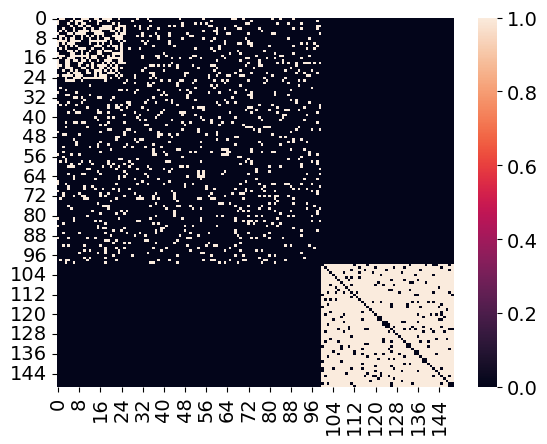

In [4]:
G = nx.to_numpy_array(G)
args.num_rois = np.sum(sizes)
args.num_comms = len(sizes)

sns.heatmap(G)

In [5]:
edges = np.stack(np.where(np.tril(G, k=-1)), axis=-1)
file = f'{BASE_path}/nw_edges.txt'
with open(f'{file}', 'w', newline='') as f:
    wr = csv.writer(f, delimiter='\t')
    wr.writerows(edges)

In [6]:
svinet_cmd = (
    f'svinet '
    f'-file {file} '
    f'-n {args.num_rois} -k {args.num_comms} '
    f'-link-sampling '
    f'-seed 1'
)
os.system(svinet_cmd)

cmd = (
    f'rm -rf {BASE_path}/svinet'
)
os.system(cmd)

cmd = (
    f'mv n{args.num_rois}-k{args.num_comms}-mmsb-seed1-linksampling '
    f'{BASE_path}/svinet'
)
os.system(cmd)

+ Output directory: n150-k3-mmsb-seed1-linksampling
+ Writing log to n150-k3-mmsb-seed1-linksampling/infer.log
+ Reading network from /home/govindas/mouse_dataset/simulations/nw_edges.txt

+ Done reading network
iteration 30: processing 1000 links

0

In [7]:
def get_comms(file):
    comms_ = np.loadtxt(file)
    comms = np.zeros((args.num_rois, args.num_comms))
    comms[comms_[:, 1].astype(int), :] = comms_[:, 2:]
    return comms

args.binwidth = 0.2
args.binrange = [0.2, 1.0]
def membership_proportions(X):
    bins = int((args.binrange[1] - args.binrange[0]) / args.binwidth)
    H = []
    for idx_comm in range(args.num_comms):
        y, _ = np.histogram(X[:, idx_comm], bins=bins, range=args.binrange)
        y = y / np.sum(y)
        H.append(y)
    H = np.nan_to_num(H)
    H = np.array(H).round(3)
    x = np.arange(args.binrange[0]+args.binwidth/2, args.binrange[1], args.binwidth)
    return H # num_comms x num_bins

X_svinet = get_comms(f'{BASE_path}/svinet/groups.txt')
H = membership_proportions(X_svinet)

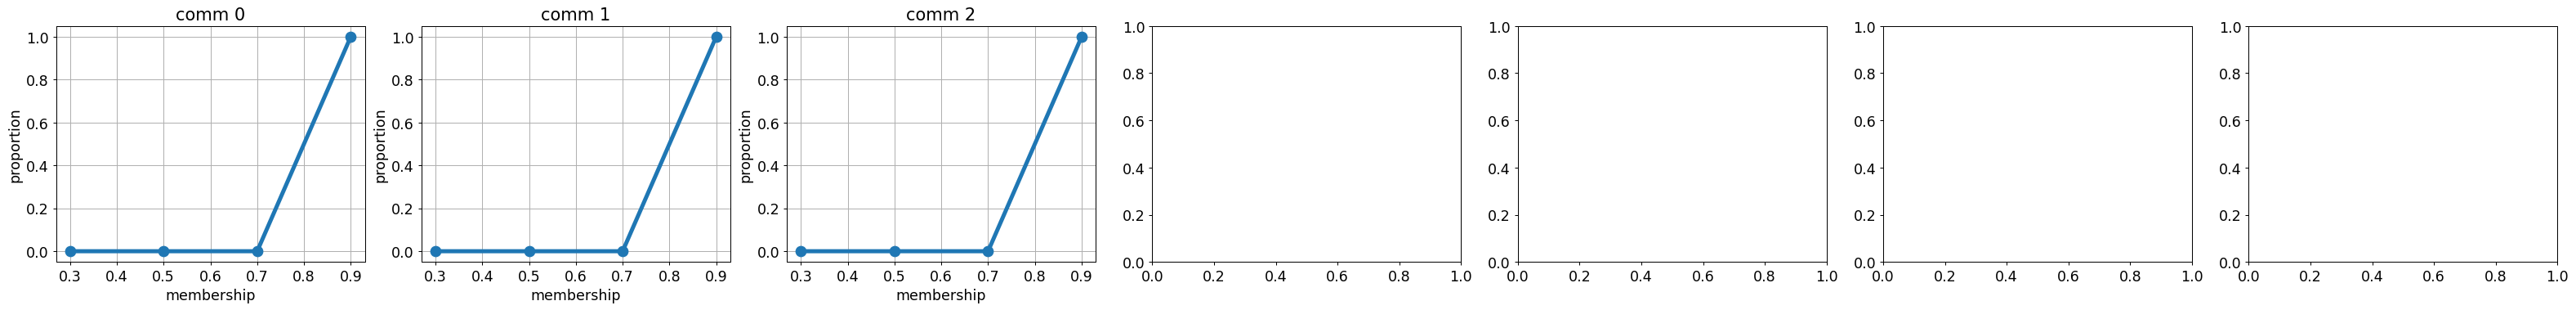

In [8]:
x = np.arange(args.binrange[0]+args.binwidth/2, args.binrange[1], args.binwidth)

ncols = 7 
nrows = int(np.ceil((args.num_comms / ncols)))
fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, 
    figsize=(5*ncols, 4*nrows), dpi=90, 
    sharex=False, sharey=False
)
fig.tight_layout()
for idx_comm in range(args.num_comms):
    ax = axs[idx_comm // ncols, idx_comm % ncols] if nrows > 1 else axs[idx_comm]
    ax.plot(x, H[idx_comm, :], linewidth=4, markersize=10, marker='o', linestyle='-')
    ax.set(title=f'comm {idx_comm}', ylabel='proportion', )#ylim=[0.0, 0.7])
    if idx_comm // ncols == nrows-1: ax.set(xlabel='membership')
    ax.grid(True)

In [9]:
# kmeans
def dsj_comms(G):
    kmeans = KMeans(
        n_clusters=args.num_comms,
        init='k-means++', n_init=50,
        random_state=args.SEED,
    ).fit(G)
    c = kmeans.predict(G)
    comms = np.zeros((args.num_rois, args.num_comms))
    for comm in range(args.num_comms):
        comms[:, comm] = (c == comm).astype(int)
    return comms

X_dsj = dsj_comms(G)

(2, 0, 1)


[Text(0.5, 1.0, 'kmeans'),
 Text(0.5, 13.90000000000002, 'comms.'),
 Text(911.05, 0.5, 'rois')]

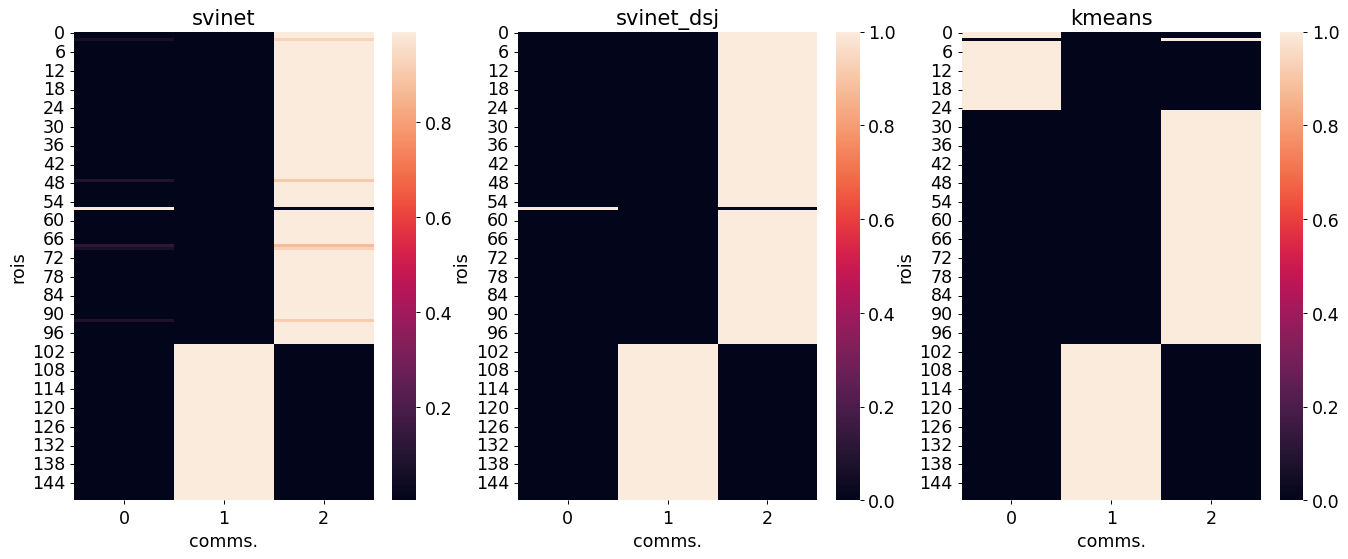

In [10]:
def align_two_partitions(args, source_comms, target_comms):
    # align source onto target
    
    # distatnce matrix
    D = 1 - cosine_similarity(target_comms.T, source_comms.T)
    # Hungarian permutation method
    best_pi = list(zip(*Munkres().compute(D)))[1]
    source_comms = source_comms[:, best_pi]
    return source_comms, best_pi

X_dsj, best_pi = align_two_partitions(args, X_dsj, X_svinet)
print(best_pi)

# svinet dsj approximation
X_ = np.zeros_like(X_svinet)
X_[np.arange(X_.shape[0]), np.argmax(X_svinet, axis=-1)] = 1

fig, axs = plt.subplots(1, 3, figsize=(15, 6), dpi=90)
fig.tight_layout()
ax = axs[0]
sns.heatmap(X_svinet, ax=ax)
ax.set(title='svinet', xlabel='comms.', ylabel='rois')
ax = axs[1]
sns.heatmap(X_, ax=ax)
ax.set(title='svinet_dsj', xlabel='comms.', ylabel='rois')
ax = axs[2]
sns.heatmap(X_dsj, ax=ax)
ax.set(title='kmeans', xlabel='comms.', ylabel='rois')